In [6]:
import numpy             as np
import matplotlib.pyplot as plt
from astropy import units as units
import sys
from pathlib import Path
from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
rcParams.update({'font.size':   8})
rcParams.update({'figure.dpi': 120})

sys.path.append('/lhome/silkem/ChemTorch/ChemTorch/')
# import os
# p=os.path.abspath(os.getcwd())
# print(p)
from src.rates          import read_specs_file

rate = 13
specs, parnt, consv = read_specs_file('C', rate)

specs_dict = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i

In [11]:

def read_data_fortran(file_name):
    '''
    Read data text file of output abundances of fortran dc models
    '''
    ## Get abundances
    with open(file_name, 'r') as file:
        dirty = []
        proper = None
        for i, line in enumerate(file):
            try:                
                if len(line) > 1: 
                    dirty.append([float(el) for el in line.split()])
            except:
                if len(dirty) != 0:
                    max_rows = len(dirty)
                    dirty = np.array(dirty)[:,1:]
                    if proper is None:
                        proper = dirty
                    else:
                        proper = np.concatenate((proper, dirty), axis = 1)
                dirty = []
        abs = proper.T

    ## get time array
    time = np.loadtxt(file_name, usecols=0, skiprows=1, max_rows=max_rows)

    return time, abs



def read_data_chemtorch(file_name):
    '''
    Read data text file of output abundances of ChemTorch models
    '''
    data = np.loadtxt(file_name,skiprows=1)
    data = data.T
    time = data[0]
    abs = data[1:-1]
    return time, abs


In [12]:
out_dc = '/lhome/silkem/ChemTorch/ChemTorch/out/dcfortran.out'
t_dc, abs_dc = read_data_fortran(out_dc)

In [13]:
out_ct = '/lhome/silkem/ChemTorch/ChemTorch/out/chemtorch.out'
t_ct, abs_ct = read_data_chemtorch(out_ct)

In [14]:
print(len(t_ct), len(t_dc))

452 180


In [23]:
from scipy.interpolate import CubicSpline

def interpolate(t,abs):
    spl= list()
    for el in abs:
        spl.append(CubicSpline(t, el))
    return spl


In [26]:
spl_ct = interpolate(t_ct, abs_ct)
spl_dc = interpolate(t_dc, abs_dc)

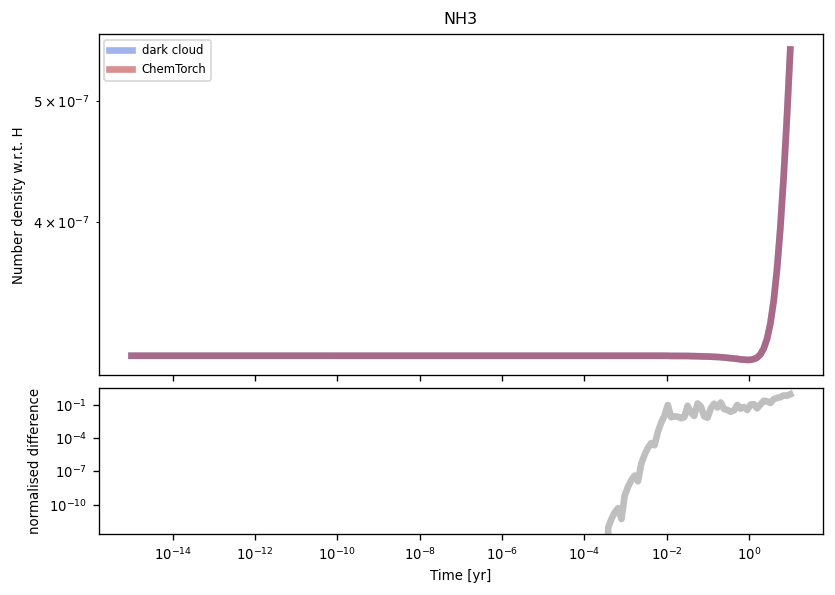

In [64]:
spec = 'NH3'
idx_spec = specs_dict[spec]
x = np.logspace(-15.,1., 200)

lw = 4
α = 0.5

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [7,3]},figsize=(7, 5))
ax1 = axs[0]
ax2 = axs[1]

ax1.set_title(spec)

ax1.plot(x, spl_dc[idx_spec](x), label = 'dark cloud', lw = lw, alpha = α, color = 'royalblue')
ax1.plot(x, spl_ct[idx_spec](x), label = 'ChemTorch' , lw = lw, alpha = α, color = 'firebrick')
diff = (np.abs(spl_dc[idx_spec](x)-spl_ct[idx_spec](x)))
ax2.plot(x,diff/max(diff), lw = lw, alpha = α, c='grey')

for ax in axs:
    ax.set_yscale('log')
    ax.set_xscale('log')
ax1.set(xticklabels=[])
# ax1.set_ylim((1.e-50, 1.0e-2))
# ax1.set_xlim((1.e-15, 1.e1))

ax2.set_xlabel('Time [yr]')
ax1.set_ylabel('Number density w.r.t. H')
ax1.legend(fontsize = 7)
ax2.set_ylabel('normalised difference')

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


plt.show()